In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.spatial import Voronoi
from typing import List, Dict, Any, Tuple
from shapely.geometry import MultiPoint, box
from shapely.ops import voronoi_diagram

## Parameters

In [2]:
# Simulation parameters
STEP_COUNT = 120            # Number of simulation frames (total steps in animation)
ANIMATION_INTERVAL = 150    # Delay between frames in milliseconds (controls animation speed)

# Field
FIELD_SIZE = (100, 100)

SEED_SPAWN_AREA = {
    "x": (20, 80),          # Horizontal spawn range for static seed points
    "y": (20, 80),          # Vertical spawn range for static seed points
}
NUM_POINTS = 7              # Number of static seed points (used for Voronoi diagram generation)

# Robot Swarm
ROBOT_SPAWN_AREA = {
    "x": (20, 80),          # Horizontal spawn range for robots
    "y": (20, 80),          # Vertical spawn range for robots
}
NUM_ROBOTS = 30             # Total number of robots in the swarm
SENSING_RADIUS = 20.0       # Radius within which robots can sense neighbors and seed points
SPEED = 1.0                 # Movement step size per simulation iteration

## Spawn Seeds

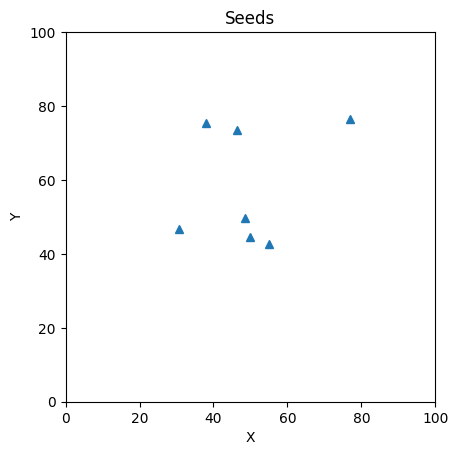

In [3]:
def spawn_points(n: int, bounds: dict[str, tuple[int, int]]) -> np.ndarray:
    """Return n random 2D points within axis-aligned bounds.

    Parameters
    ----------
    n : int
        Number of points.
    bounds : dict[str, tuple[int, int]]
        Dictionary with keys "x" and "y" mapping to (min, max).

    Returns
    -------
    np.ndarray
        Array of shape (n, 2) with [x, y] rows.
    """
    xs = np.random.uniform(bounds["x"][0], bounds["x"][1], size=n)
    ys = np.random.uniform(bounds["y"][0], bounds["y"][1], size=n)
    return np.c_[xs, ys]

# Demo
seed_coords = spawn_points(NUM_POINTS, SEED_SPAWN_AREA)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Seeds")
ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
plt.show()

## Spawn Robots

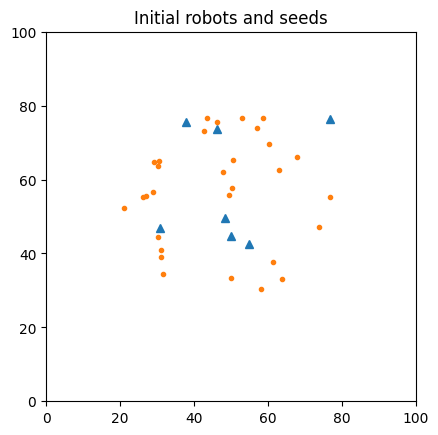

In [4]:
robot_coords = spawn_points(NUM_ROBOTS, ROBOT_SPAWN_AREA)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Initial robots and seeds")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
ax.plot(robot_coords[:,0], robot_coords[:,1], 'o', markersize=3)
plt.show()

## Sensing

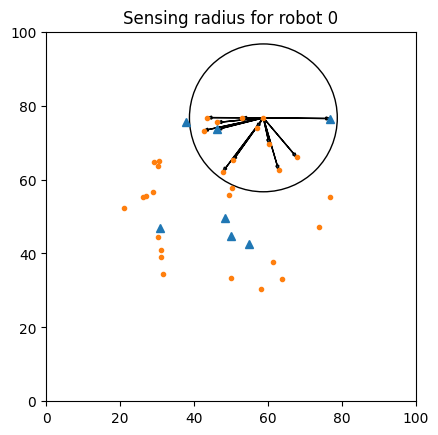

In [5]:
def sensor(
    robot_coords: np.ndarray,
    seed_coords: np.ndarray,
    sensing_radius: float
) -> List[Dict[str, List[Dict[str, Any]]]]:
    """Return local neighbor and seed info per robot within sensing radius.

    Notes
    -----
    - Neighbor 'vector' is neighbor_pos - robot_pos.
    - Seed 'vector' is seed_pos - robot_pos.

    Parameters
    ----------
    robot_coords : np.ndarray
        Robot positions, shape (R, 2).
    seed_coords : np.ndarray
        Seed positions, shape (S, 2).
    sensing_radius : float
        Euclidean range.

    Returns
    -------
    List[Dict[str, List[Dict[str, Any]]]]
        For each robot, a dict with lists 'robots' and 'seeds'.
    """
    num_robots = len(robot_coords)
    results: List[Dict[str, List[Dict[str, Any]]]] = []
    radius_sq = sensing_radius ** 2

    for robot_idx in range(num_robots):
        current_robot_coords = robot_coords[robot_idx]

        # Nearby robots
        relative_robot_vectors = robot_coords - current_robot_coords
        robot_distances_sq = np.einsum("ij,ij->i", relative_robot_vectors, relative_robot_vectors)
        robot_distances_sq[robot_idx] = np.inf  # ignore self
        neighbor_indices = np.where(robot_distances_sq <= radius_sq)[0]

        nearby_robots = [
            {
                "id": int(neighbor_id),
                "vector": relative_robot_vectors[neighbor_id],
                "distance": float(np.sqrt(robot_distances_sq[neighbor_id])),
            }
            for neighbor_id in neighbor_indices
        ]

        # Nearby seed points
        relative_point_vectors = seed_coords - current_robot_coords
        point_distances_sq = np.einsum("ij,ij->i", relative_point_vectors, relative_point_vectors)
        nearby_point_indices = np.where(point_distances_sq <= radius_sq)[0]

        nearby_points = [
            {
                "id": int(point_id),
                "position": (float(seed_coords[point_id, 0]), float(seed_coords[point_id, 1])),
                "vector": relative_point_vectors[point_id],
                "distance": float(np.sqrt(point_distances_sq[point_id])),
            }
            for point_id in nearby_point_indices
        ]

        results.append({
            "robots": nearby_robots,
            "seeds": nearby_points
        })

    return results

# Demo: visualize sensing for robot k
active_robot_index = 0
scans = sensor(robot_coords, seed_coords, SENSING_RADIUS)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title(f"Sensing radius for robot {active_robot_index}")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', linestyle='None')
ax.plot(robot_coords[:, 0], robot_coords[:, 1], 'o', markersize=3)
circle = plt.Circle(robot_coords[active_robot_index], SENSING_RADIUS, fill=False)
ax.add_patch(circle)

# neighbor vectors
for nb in scans[active_robot_index]["robots"]:
    v = nb['vector']
    ax.arrow(robot_coords[active_robot_index, 0], robot_coords[active_robot_index, 1], v[0], v[1],
             head_width=0.8, length_includes_head=True)

# seed point vectors
for pt in scans[active_robot_index]["seeds"]:
    v = pt['vector']
    ax.arrow(robot_coords[active_robot_index, 0], robot_coords[active_robot_index, 1], v[0], v[1],
             head_width=0.8, length_includes_head=True)

plt.show()

## Behavior Decomposition (single robot, for illustration)

Local neighbors: 10
Local seeds: 2
Repulsion vector: [0.41027875 0.49228094] Drive vector: [0.99303423 0.11782625]


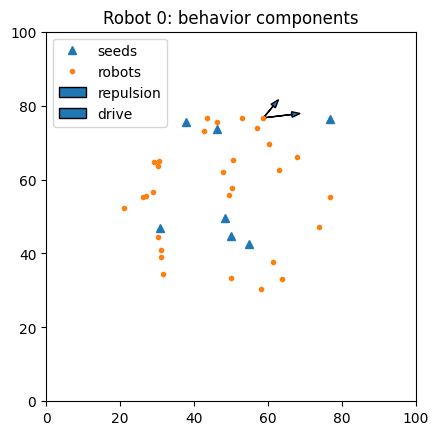

In [6]:
def behavior(
    robot_index: int,
    robot_positions: np.ndarray,
    sensing_radius: float,
):
    """Compute illustrative repulsion and drive vectors for one robot.

    Parameters
    ----------
    robot_index : int
        Index of robot to analyze.
    robot_positions : np.ndarray
        Array of shape (R, 2).
    sensing_radius : float
        Local sensing radius.

    Returns
    -------
    tuple
        (neighbors, seeds, repulsion_vector, drive_vector)
    """
    # Local sensing
    scan = sensor(robot_positions, seed_coords, sensing_radius)[robot_index]
    neighbors = scan["robots"]
    seeds = scan["seeds"]

    # Repulsion from nearby neighbors
    repulsion_vector = np.zeros(2)
    for neighbor in neighbors:
        distance = neighbor["distance"]
        if distance <= 1e-6:
            continue
        if distance < sensing_radius / 2:
            # -(r / d) * (1/d^2) == -r / d^3
            repulsion_vector -= (neighbor["vector"] / distance) * (1.0 / distance**2)
    repulsion_vector *= 5.0

    # Attraction/drive using nearest and farthest seeds
    if len(seeds) >= 2:
        sorted_seeds = sorted(seeds, key=lambda s: s["distance"])
        closest_seed = sorted_seeds[0]
        farthest_seed = sorted_seeds[-1]
        drive_vector = (
            (farthest_seed["vector"] / max(farthest_seed["distance"], 1e-9)) -
            (closest_seed["vector"] / max(closest_seed["distance"], 1e-9))
        )
        n = np.linalg.norm(drive_vector)
        if n > 1e-6:
            drive_vector /= n
    else:
        drive_vector = np.zeros(2)

    return neighbors, seeds, repulsion_vector, drive_vector

# Demo
(
    local_neighbors,
    local_seeds,
    repulsion_vector,
    drive_vector
) = behavior(active_robot_index, robot_coords, SENSING_RADIUS)

print("Local neighbors:", len(local_neighbors))
print("Local seeds:", len(local_seeds))
print("Repulsion vector:", repulsion_vector, "Drive vector:", drive_vector)

# Visualization
fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title(f"Robot {active_robot_index}: behavior components")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', linestyle='None', label="seeds")
ax.plot(robot_coords[:, 0], robot_coords[:, 1], 'o', markersize=3, label="robots")

ARROW_SCALE = 10.0
ax.arrow(
    robot_coords[active_robot_index, 0],
    robot_coords[active_robot_index, 1],
    repulsion_vector[0] * ARROW_SCALE,
    repulsion_vector[1] * ARROW_SCALE,
    head_width=1.5,
    length_includes_head=True,
    label="repulsion"
)
ax.arrow(
    robot_coords[active_robot_index, 0],
    robot_coords[active_robot_index, 1],
    drive_vector[0] * ARROW_SCALE,
    drive_vector[1] * ARROW_SCALE,
    head_width=1.5,
    length_includes_head=True,
    label="drive"
)
ax.legend()
plt.show()

## Synchronous, Vectorized One-Step Update
Fully synchronous. No movement threshold. If any force exists globally,
robots with a zero net force receive a small random unit step so no one stalls.

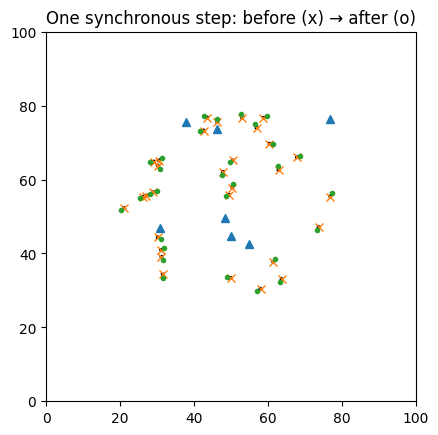

In [7]:
def one_step_sync(robot_positions: np.ndarray) -> np.ndarray:
    """Return next positions after one synchronous, vectorized step.

    Mechanics
    ---------
    - Repulsion: sum over neighbors within SENSING_RADIUS/2, using -r/d^3, scaled by 5.
    - Drive: if at least two seeds within SENSING_RADIUS, use
             unit( far_vec/far_d - near_vec/near_d ), else 0.
    - No cutoff. If any robot experiences nonzero total force, robots with zero
      net force take a random unit step to avoid stalling.
    - All updates computed from the same prior positions (synchronous).

    Parameters
    ----------
    robot_positions : np.ndarray
        Array of shape (R, 2).

    Returns
    -------
    np.ndarray
        New positions of shape (R, 2), clipped to the field.
    """
    R = robot_positions.shape[0]

    # --- Repulsion among robots (vectorized) ---
    # R_ij = pos_j - pos_i
    Rij = robot_positions[None, :, :] - robot_positions[:, None, :]
    Dij = np.linalg.norm(Rij, axis=2)
    # Ignore self
    np.fill_diagonal(Dij, np.inf)

    # Consider neighbors within half radius
    rep_mask = Dij < (SENSING_RADIUS / 2.0)

    # Contribution = -R_ij / d^3 for masked entries, else 0
    with np.errstate(divide="ignore", invalid="ignore"):
        Dij_cubed = np.where(rep_mask, Dij**3, np.inf)
        rep_term = -Rij / Dij_cubed[:, :, None]
        rep_term[~rep_mask] = 0.0
    repulsion = 5.0 * np.sum(rep_term, axis=1)  # (R,2)

    # --- Drive from seeds (vectorized) ---
    # S_is = seed_s - pos_i
    Svec = seed_coords[None, :, :] - robot_positions[:, None, :]   # (R,S,2)
    Sd = np.linalg.norm(Svec, axis=2)                              # (R,S)
    seed_mask = Sd <= SENSING_RADIUS

    # For nearest: set outside to +inf then argmin
    Sd_near = np.where(seed_mask, Sd, np.inf)
    idx_near = np.argmin(Sd_near, axis=1)                          # (R,)
    d_near = Sd[np.arange(R), idx_near]                             # (R,)
    v_near = Svec[np.arange(R), idx_near, :]                        # (R,2)

    # For farthest: set outside to -inf then argmax
    Sd_far = np.where(seed_mask, Sd, -np.inf)
    idx_far = np.argmax(Sd_far, axis=1)                             # (R,)
    d_far = Sd[np.arange(R), idx_far]                                # (R,)
    v_far = Svec[np.arange(R), idx_far, :]                           # (R,2)

    # Valid drive where count of seeds within radius >= 2
    seed_counts = np.sum(seed_mask, axis=1)                          # (R,)
    valid_drive = seed_counts >= 2

    # Raw drive and normalization
    with np.errstate(divide="ignore", invalid="ignore"):
        drive_raw = (v_far / np.maximum(d_far[:, None], 1e-9)) - (v_near / np.maximum(d_near[:, None], 1e-9))
    drive_raw[~valid_drive] = 0.0
    norms = np.linalg.norm(drive_raw, axis=1)
    drive = np.zeros_like(drive_raw)
    nz = norms > 1e-6
    drive[nz] = (drive_raw[nz].T / norms[nz]).T  # row-wise unit

    # --- Total movement direction ---
    move = repulsion + drive                           # (R,2)

    # If any force exists globally, ensure no robot stalls with exact zero.
    any_force = np.any(np.linalg.norm(move, axis=1) > 0.0)
    if any_force:
        zero_rows = np.linalg.norm(move, axis=1) == 0.0
        if np.any(zero_rows):
            # Assign random unit directions to zero rows
            rng = np.random.default_rng()
            rand = rng.normal(size=(np.sum(zero_rows), 2))
            rand_norm = np.linalg.norm(rand, axis=1)
            rand[rand_norm > 0] = (rand[rand_norm > 0].T / rand_norm[rand_norm > 0]).T
            move[zero_rows] = rand

    # Normalize all nonzero rows and step
    move_norms = np.linalg.norm(move, axis=1)
    nonzero = move_norms > 0.0
    steps = np.zeros_like(move)
    steps[nonzero] = (move[nonzero].T / move_norms[nonzero]).T * SPEED

    new_positions = robot_positions + steps
    new_positions[:, 0] = np.clip(new_positions[:, 0], 0, FIELD_SIZE[0])
    new_positions[:, 1] = np.clip(new_positions[:, 1], 0, FIELD_SIZE[1])
    return new_positions

# Demo: before/after one synchronous step
pos_before = robot_coords.copy()
robot_coords = one_step_sync(robot_coords)
pos_after = robot_coords.copy()

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("One synchronous step: before (x) → after (o)")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
ax.plot(pos_before[:,0], pos_before[:,1], 'x')
ax.plot(pos_after[:,0], pos_after[:,1], 'o', markersize=3)
for i in range(len(pos_before)):
    dx, dy = pos_after[i] - pos_before[i]
    ax.arrow(pos_before[i,0], pos_before[i,1], dx, dy, head_width=0.8, length_includes_head=True)
plt.show()

## Voronoi Drawing

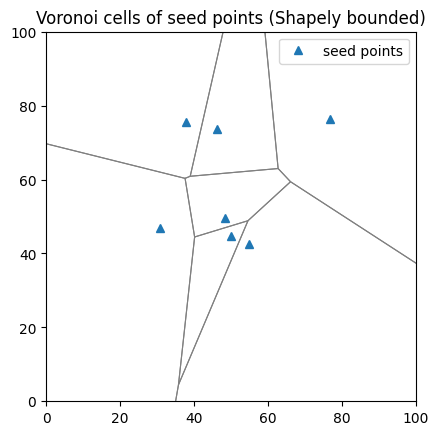

In [8]:
def draw_voronoi(points: np.ndarray, width: int, height: int, ax, artists_store: list):
    """Draw a bounded Voronoi diagram for `points` on `ax`.

    Parameters
    ----------
    points : np.ndarray
        Input sites, shape (N,2).
    width : int
        Width of bounding box.
    height : int
        Height of bounding box.
    ax : matplotlib.axes.Axes
        Target axes.
    artists_store : list
        A list that will store created artists for later clearing.
    """
    # clear old artists
    for artist in artists_store:
        artist.remove()
    artists_store.clear()

    if len(points) < 2:
        return

    # build bounded diagram
    bbox = box(0, 0, width, height)
    mp = MultiPoint([tuple(p) for p in points])
    cells = voronoi_diagram(mp, envelope=bbox, edges=False)  # polygons, already clipped

    # draw polygons
    for poly in cells.geoms:
        x, y = poly.exterior.xy
        line, = ax.plot(x, y, 'gray', lw=0.8, zorder=0)
        artists_store.append(line)
        # optional: draw holes if present
        for ring in poly.interiors:
            xi, yi = ring.xy
            hole, = ax.plot(xi, yi, 'gray', lw=0.6, zorder=0)
            artists_store.append(hole)

# Demo
fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title("Voronoi cells of seed points (Shapely bounded)")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', label='seed points')

voronoi_artists = []
draw_voronoi(seed_coords, FIELD_SIZE[0], FIELD_SIZE[1], ax, voronoi_artists)
ax.legend()
plt.show()

## Full Run Animation (synchronous, vectorized updates)

In [9]:
PATHS: List[list] = [[robot_coords[i].copy()] for i in range(NUM_ROBOTS)]

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Full run")
ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')

scatters = [ax.plot([], [], 'o', markersize=4)[0] for _ in range(NUM_ROBOTS)]
trails = [ax.plot([], [], '-', linewidth=1, alpha=0.25)[0] for _ in range(NUM_ROBOTS)]
voronoi_lines = []
frame_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=10,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

def update(frame: int):
    """Animation update. Uses synchronous, vectorized step."""
    global robot_coords

    # Synchronous vectorized step from prior frame
    robot_coords = one_step_sync(robot_coords)

    # Draw
    for i in range(NUM_ROBOTS):
        PATHS[i].append(robot_coords[i].copy())
        xs, ys = zip(*PATHS[i])
        scatters[i].set_data([xs[-1]], [ys[-1]])
        trails[i].set_data(xs, ys)

    # Voronoi overlay (seeds are static)
    draw_voronoi(seed_coords, FIELD_SIZE[0], FIELD_SIZE[1], ax, voronoi_lines)
    frame_text.set_text(f"Frame: {frame+1}/{STEP_COUNT}")
    if frame == STEP_COUNT - 1:
        for t in trails:
            t.set_data([], [])
    return scatters + trails + voronoi_lines + [frame_text]

ani = FuncAnimation(fig, update, frames=STEP_COUNT, interval=ANIMATION_INTERVAL, blit=True, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())